# Faster RCNN

从RCNN网络开始，用region proposal代替了滑动窗口式的遍历检测

之后的SPP Net，开启了统一提取特征并在feature map上的特征提取

而后，Fast RCNN则是将回归与分类结合起来，形成了多任务训练模型

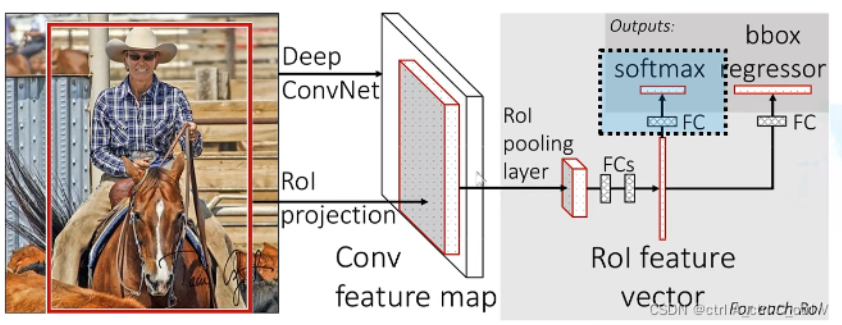

下面该如何改进？

## Motivation

虽然Fast RCNN很优雅，但是其存在一个源生性缺陷：selective search

selective search固然是代替滑动窗口来实现目标检测的里程碑式工作，但目前已经严重阻碍了目标检测的发展。

主要的阻碍分为两个方面：

1. 速度慢：selective search步骤占据了fast RCNN中的大多数运算时间

2. 精度差：无论如何，selective search是一个基于手工特征的方法，本身依然存在泛化性不足的问题(迷彩服)

这样一来，如何改进selective search，则变成了实现现代目标检测算法中的最关键的一个步骤。


为了改进selective search，一个直接的想法就是利用神经网络。

那么一个什么样的神经网络可以满足要求呢？

这样的神经网络又该如何训练呢？

## 基本思路：RPN网络

Region Proposal Network， 其目的是接受图像的输入，并输出可能存在目标的框。那么如何实现？

1. 要找出粗略的目标的话，首先要对模型进行特征提取。如何做？

用imagenet模型参数作为初始参数，提取自然图像中的高纬特征。

将得到的高维特征作为输入，我们希望新的网络从中预测出潜在的框的位置。

2. 如何找到潜在框的位置？

本质上就是针对**特征层面**的selective search。

这也是faster rcnn中最关键的内容。






#### 目标区域推荐

假设我们已经训练好了一个网络，这个网络能对输入的大尺寸的feature map中得到若干个不同尺寸的框。

那么这个流程，应当可以借鉴传统的目标检测方法，即滑动窗口的方式。

用一个固定大小的窗口对feature map中的元素进行遍历，每个窗口对应了原图像中的一个区域。

把这个窗口截取的feature map进行后续的分类和回归，来判断这个窗口是否存在目标，以及应该框在哪里。

**注意** 这里的目标依然是固定尺寸的。针对目标可能存在比例、尺度的不同，这里对每个feature进行不同尺寸窗口的截取。

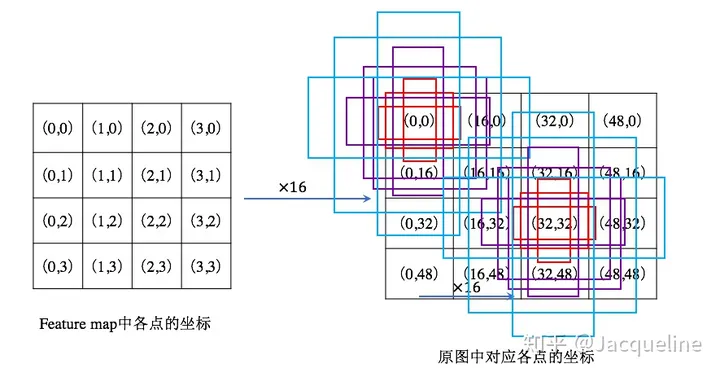


具体上，窗口中存在3种比例，3种尺度。分别是

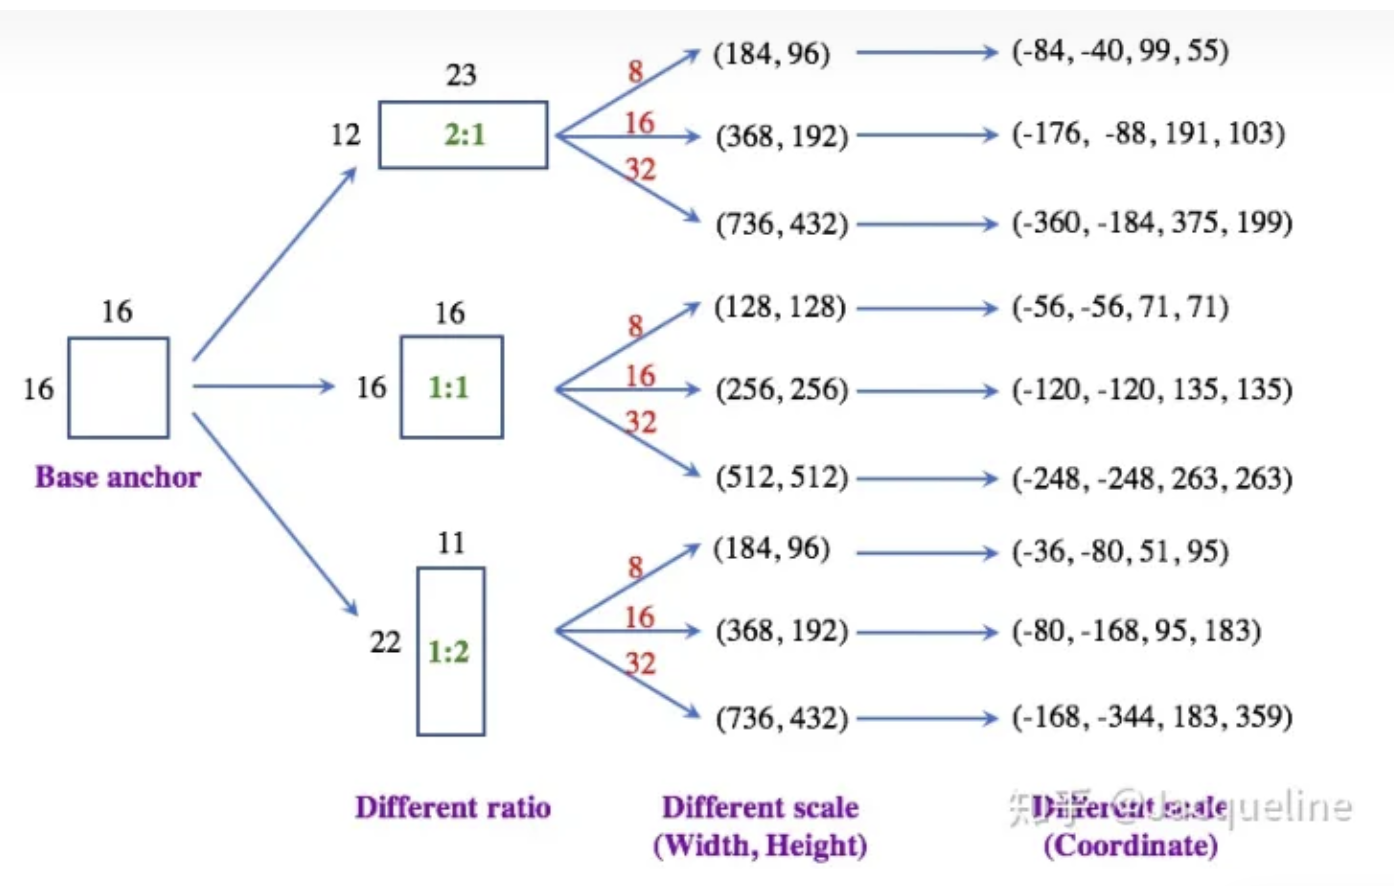

一张featuremap中可以提取多个不同尺度的proposal。

对每个proposal进行预测，（**判断这里的框是/否是目标，而不是是哪一类**），即可得到正例样本。

同时不要忘记进行nms，最终可以输出推荐出来的，可能存在区域的样本。



**问题：如何训练这样的网络？**

* 将imagenet的模型载入base net
* 输入一张图像，得到feature map
* 根据输入图像的目标框位置，得到若干正样本以及对应数量的负样本

```
选择正负样本应当遵循一下原则：

1. Anchor boxes与ground truth框的IoU大于0.7的每个anchor box标记为正样本。因为IoU较大表示anchor box与ground truth框有较好的匹配。
2. Anchor boxes与所有的ground truth框的IoU都小于0.3的每个anchor box标记为负样本。因为IoU较小表明anchor box可能是背景或误检。
3. Anchor boxes与某个ground truth框的IoU在0.3到0.7之间的不参与训练。因为这些anchor box难以清晰判断是正样本还是负样本。
4. 每个ground truth框最多只能匹配一个anchor box。如果多个anchor box与同一ground truth框IoU都大于0.7,则选择IoU最大的那一个作为正样本,其余不参与训练。
5. 每个ground truth框至少要匹配一个anchor box作为正样本。如果没有任何anchor box可以匹配,则选择与该ground truth框IoU最接近0.7的anchor box作为正样本。（想一下为什么？）
6. 对于未匹配到任何ground truth框的anchor boxes,标记为负样本。
7. 保证正负样本数量比例为1:1或1:3,过度不平衡会影响模型的收敛。
```

* 最后，将选择到的正负样本送入网络进行训练，让模型充分认识到哪些区域可能会存在特征
* 根据联合损失(分类+回归)得到目标框的位置

根据以上内容，我们可以大致画出rpn模型的草图如下

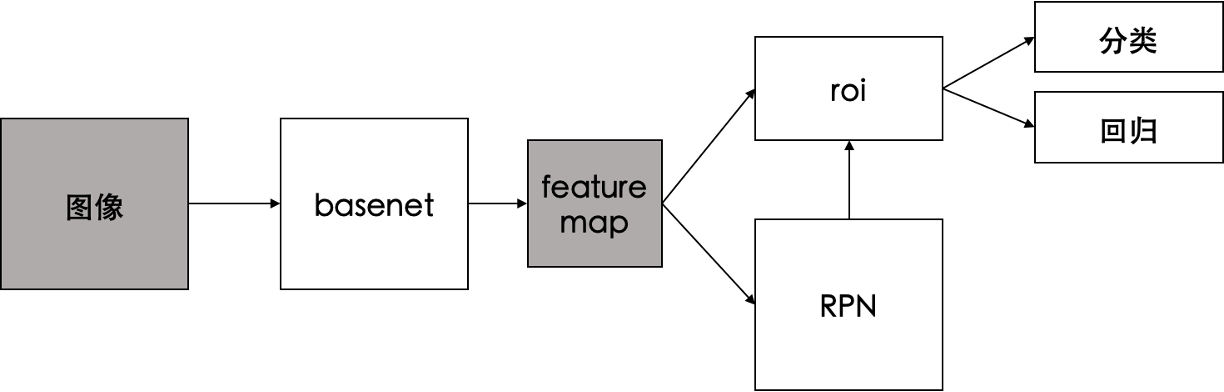

那么根据这个网络，我们就可以彻底甩掉selective search，用上述网络实现目标区域的粗筛选。

（为什么是粗筛选？）



## Faster RCNN的进一步优化

在得到RPN网络后，一个直接的感受就是

* 图像先进入RPN进行区域推荐
* 图像进入fast rcnn进行训练，只不过selective search的部分，由rpn得到

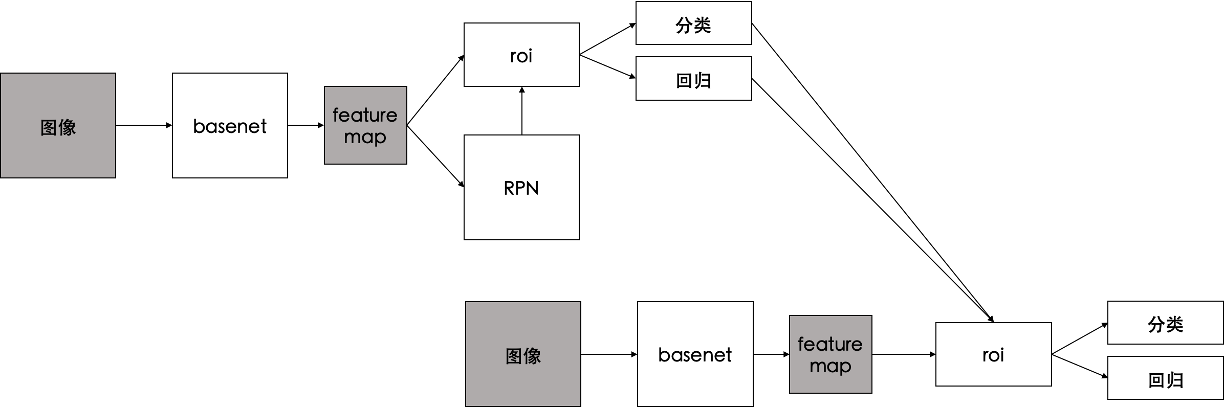

显然，这样做是一种极大的浪费，因为图像会被提取两次basenet，极大地降低了效率。

为何不将这两个网络进行合并？

也就是说他们的basenet应当公用。

这样的话，就可以一次提取特征，用于rpn和后续检测。

最终，faster rcnn的框图如下图所示

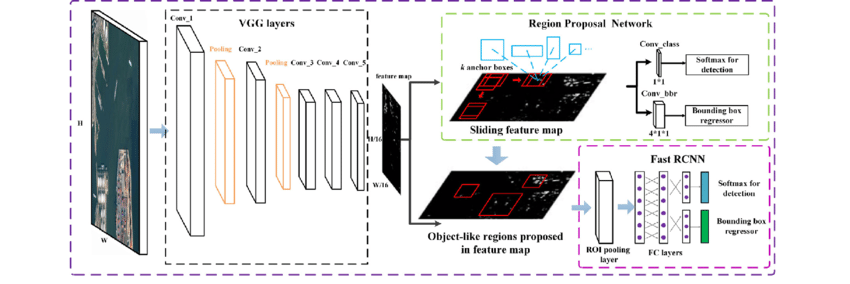

### 训练

那么这样的一个网络该如何训练？


1. 将imagenet的模型载入basenet，然后训练RPN模块(basenet部分不更新)

2. 带入RPN模块，三部分进行统一训练。

**损失函数**

关于损失函数部分，rpn会得到cls_rpn和reg_rpn；rcnn那部分会得到cls_rcnn和reg_rcnn，

将上述两部分特征加起来，就是最终的损失。

一张便于理解的框图

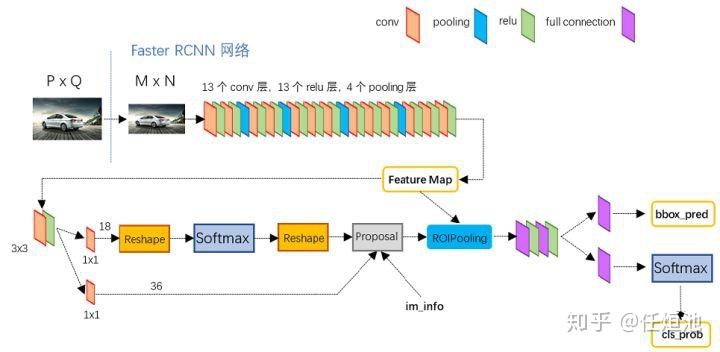